# Interpretable Propensity Modeling for Term-Deposit Marketing

## 1. Business Problem

A bank runs phone marketing campaigns for **term deposit** products. The practical question is:

**Which customers should we contact first, if call capacity is limited?**

Instead of only maximising model accuracy, the goal is to produce **actionable and explainable segments** that can support targeting and prioritisation.

## 2. Data

- Source: UCI Bank Marketing dataset (bank-full.csv)  
- Rows: **45,212**  
- Positive label: **5,289**  with Overall subscription rate: 11.7% (5289 / 45212)
- Target `y`: `1` means the customer **subscribed a term deposit** after the campaign

## 3. Core Approach (RFM + SMOTENC)

- **RFM scoring (quantile bins)**: convert behavioural / relationship signals into ordinal scores (1–5) for robustness and easier interpretation
- **SMOTENC**: handle class imbalance with mixed feature types (categorical + numerical)
- **Decision tree**: Although gradient boosting models (e.g., XGBoost or LightGBM) may achieve slightly higher AUC, we use a Decision Tree here because it allows direct extraction of business-readable segments.


In [31]:
# Step 1: Load data
import pandas as pd
import numpy as np

df = pd.read_csv(
    r"/Users/zhangnan/Documents/2025ba/foundation of ba/group/bank+marketing/bank/bank-full.csv",
    sep=";"
)


In [32]:
# Step 2: Define label
y = df["y"].map({"no": 0, "yes": 1})


## 4. Feature Engineering: RFM Scoring

To make behavioural features more robust and easier to read, we convert raw metrics into **ordinal RFM scores (1–5)** using quantile binning.

In this dataset there is no long customer history table, so we use available relationship signals:
- Recency: days since last contact (`pdays`, with a special value for "never contacted")
- Frequency: number of contacts in the current campaign (`campaign`)
- Monetary: account balance (`balance`)


In [33]:
# Step 3: Build RFM scores (quantile bins)


# make sure we have a unique id
if "customer_id" not in df.columns:
    df["customer_id"] = df.index

# basic financial flags
df["F_contacts"] = df["campaign"]
df["R_never_contacted"] = (df["pdays"] == 999).astype(int)
df["M_negative_balance"] = (df["balance"] < 0).astype(int)

# treat 999 as least recent
recency_for_score = df["pdays"].where(
    df["pdays"] != 999,
    df["pdays"].max() + 1
)

def _qcut_score(series, reverse=False, n_bins=5):
    out = pd.Series(pd.NA, index=series.index, dtype="Int64")
    mask = series.notna()

    if mask.sum() == 0:
        return out

    bins = pd.qcut(series[mask], q=n_bins, duplicates="drop", labels=False)
    k = int(bins.max()) + 1

    score = (k - bins) if reverse else (bins + 1)
    out.loc[mask] = score.astype("int64")

    return out

# generate RFM scores
df["R_score"] = _qcut_score(recency_for_score, reverse=True)
df["F_score"] = _qcut_score(df["F_contacts"], reverse=False)
df["M_score"] = _qcut_score(df["balance"], reverse=False)

df["RFM_score"] = (
    df["R_score"].fillna(0)
    + df["F_score"].fillna(0)
    + df["M_score"].fillna(0)
)




R, F, M scores are built with quantile binning (`pd.qcut`) and range from **1 to 5**.

- **1 = low** (bottom quantile)
- **3 = medium**
- **5 = high** (top quantile)

For Recency, a **smaller** value means more recent contact, so the score is reversed.


## 5. Feature Strategy

We organise features into three layers (close to real marketing work):

- **Demographics**: who the customer is
- **RFM / relationship signals**: where the customer is in the contact lifecycle
- **Product constraints**: whether the customer already has loans / housing loans / defaults


In [34]:
# Step 4: Define feature groups
rfm_cols = ["R_score", "F_score", "M_score", 
            "R_never_contacted", "M_negative_balance"]

product_cols = ["loan", "housing", "default"]

X = df[demographic_cols + rfm_cols + product_cols]



In [35]:
# Step 5: Categorical vs numerical (for SMOTENC)
cat_cols = ["job", "marital", "education", "loan", "housing", "default"]

num_cols = ["age", "R_score", "F_score", "M_score", "R_never_contacted", "M_negative_balance"]


In [36]:
# Step 6: Train–Test Split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [37]:
# Step 7:One-hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)


In [39]:
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)


In [40]:
# Step 8:SMOTENC
from imblearn.over_sampling import SMOTENC


In [41]:
# get categorical feature indices after one-hot
cat_feature_indices = []

ohe = preprocessor.named_transformers_["cat"]
cat_feature_indices = list(
    range(ohe.transform(X_train[cat_cols]).shape[1])
)


In [42]:
smote = SMOTENC(
    categorical_features=cat_feature_indices,
    random_state=42
)


In [43]:
X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)


In [44]:
# Step 9:Decision Tree
from sklearn.tree import DecisionTreeClassifier


In [45]:
tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=200,
    random_state=42
)


In [46]:
tree.fit(X_train_res, y_train_res)


DecisionTreeClassifier(max_depth=4, min_samples_leaf=200, random_state=42)

In [47]:
# Step 10:evaluation tree
from sklearn.metrics import roc_auc_score, average_precision_score


In [48]:
y_pred_proba = tree.predict_proba(X_test_enc)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

roc_auc, pr_auc


(0.6251170130273319, 0.1656315535884627)

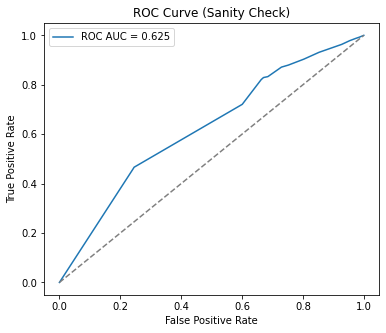

In [49]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Sanity Check)")
plt.legend()
plt.show()


## 7. Model Validation

We report ROC / PR curves only as a sanity check.  
The main goal is ranking and segmentation for marketing actions, not a pure prediction benchmark.


## 8. Complexity Control

We keep the tree shallow on purpose (interpretability first).  
A quick pruning-path check is used to confirm the chosen depth is reasonable.


In [50]:

try:
    path = tree.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas = path.ccp_alphas
except ValueError:
    ccp_alphas = None


We inspect the cost-complexity pruning path to confirm the tree is not overly complex for segmentation use.

## 9. Business Metric: Top-10 Gains

For marketing, a useful question is: *if we call only the top 10% customers ranked by the model, how many conversions can we capture?*


In [53]:
# Step 11: Top-10 Gains
top_k = int(0.1 * len(y_test))
top_k_idx = y_pred_proba.argsort()[::-1][:top_k]
top10_gain = y_test.iloc[top_k_idx].sum() / y_test.sum()



In [54]:
top10_gain


0.16257088846880907

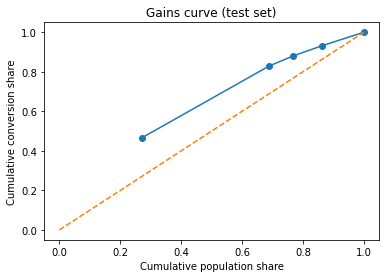

In [55]:
# Step 11b: Decile table + gains curve (test set)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

scores = pd.DataFrame({"y": y_test.values, "p": y_pred_proba})
scores["decile"] = pd.qcut(scores["p"], 10, labels=False, duplicates="drop")

decile = (
    scores.groupby("decile")
    .agg(n=("y", "size"), positives=("y", "sum"), avg_score=("p", "mean"))
    .sort_index(ascending=False)
)

decile["rate"] = decile["positives"] / decile["n"]
decile["cum_pop_share"] = decile["n"].cumsum() / decile["n"].sum()
decile["cum_pos_share"] = decile["positives"].cumsum() / decile["positives"].sum()

decile

plt.figure(figsize=(6, 4))
plt.plot(decile["cum_pop_share"], decile["cum_pos_share"], marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Cumulative population share")
plt.ylabel("Cumulative conversion share")
plt.title("Gains curve (test set)")
plt.show()


**Result (test set).** If we contact only the top 10% customers ranked by the model, we can capture **16.3%** of all subscriptions.  
This is about **1.63× lift** compared with random targeting.


In [63]:
# Step 12:split rule summary
import pandas as pd
import numpy as np
from sklearn.tree import _tree


## 10. Interpretable Segment Rules

We extract the main decision rules from the tree and summarise each segment by:
- population size
- conversion rate
- examples of the rule conditions

This makes it easy to translate the model into targeting logic.


In [57]:
def extract_tree_rules(tree, X, y, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            recurse(tree_.children_left[node],
                    path + [f"{name} ≤ {threshold:.2f}"])
            recurse(tree_.children_right[node],
                    path + [f"{name} > {threshold:.2f}"])
        else:
            paths.append((node, path))

    recurse(0, [])

    records = []
    leaf_ids = tree.apply(X)

    for node_id, rule in paths:
        idx = leaf_ids == node_id
        samples = idx.sum()
        if samples == 0:
            continue

        pos_rate = y[idx].mean()
        proportion = samples / len(y)

        records.append({
            "samples": samples,
            "proportion": round(proportion, 3),
            "pos_rate": round(pos_rate, 3),
            "rule": " AND ".join(rule)
        })

    return pd.DataFrame(records).sort_values("pos_rate", ascending=False)


In [58]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)


In [59]:
rule_summary = extract_tree_rules(
    tree=tree,
    X=X_train_enc,
    y=y_train.values,
    feature_names=preprocessor.get_feature_names_out()
)

rule_summary


,samples,proportion,pos_rate,rule
10,133,0.004,0.233,cat__housing_no > 0.50 AND cat__loan_yes ≤ 0.50 AND cat__job_blue-collar > 0.50 AND num__age ≤ 29.50
8,8460,0.267,0.203,cat__housing_no > 0.50 AND cat__loan_yes ≤ 0.50 AND cat__job_blue-collar ≤ 0.50 AND cat__job_technician ≤ 0.50
9,2084,0.066,0.145,cat__housing_no > 0.50 AND cat__loan_yes ≤ 0.50 AND cat__job_blue-collar ≤ 0.50 AND cat__job_technician > 0.50
12,262,0.008,0.137,cat__housing_no > 0.50 AND cat__loan_yes > 0.50 AND num__age ≤ 29.79
11,1348,0.043,0.093,cat__housing_no > 0.50 AND cat__loan_yes ≤ 0.50 AND cat__job_blue-collar > 0.50 AND num__age > 29.50
0,10753,0.340,0.086,cat__housing_no ≤ 0.50 AND cat__education_primary ≤ 0.50 AND cat__loan_yes ≤ 0.50 AND cat__job_services ≤ 0.50
1,1390,0.044,0.075,cat__housing_no ≤ 0.50 AND cat__education_primary ≤ 0.50 AND cat__loan_yes ≤ 0.50 AND cat__job_services > 0.50
5,771,0.024,0.075,cat__housing_no ≤ 0.50 AND cat__education_primary > 0.50 AND num__age ≤ 42.50 AND num__age > 35.50
13,1453,0.046,0.075,cat__housing_no > 0.50 AND cat__loan_yes > 0.50 AND num__age > 29.79 AND cat__education_primary ≤ 0.50
2,2213,0.070,0.067,cat__housing_no ≤ 0.50 AND cat__education_primary ≤ 0.50 AND cat__loan_yes > 0.50 AND num__M_negative_balance ≤ 0.00


The rule summary shows a trade-off: very high conversion segments are small, while some medium-size segments still have strong conversion and are more practical for targeting.

In [60]:
# Step 13:SHAP
import shap


In [61]:
explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(X_train_res)


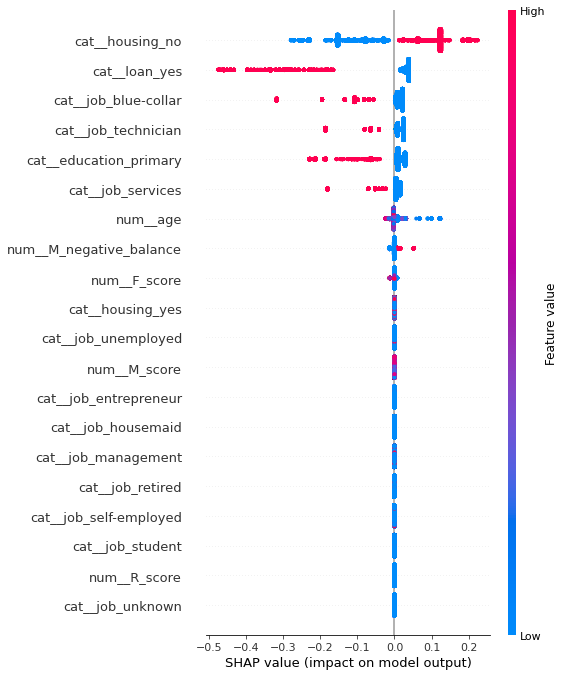

In [62]:
shap.summary_plot(
    shap_values[1],
    X_train_res,
    feature_names=preprocessor.get_feature_names_out()
)


## 11. SHAP Explanation

SHAP provides a global check: the most important features in SHAP should be consistent with the main splits in the tree rules.


## 12. Business Recommendations


- **Segment A: No housing loan + no personal loan (large + high conversion)**  
  - Criteria (tree rule): `housing = no` and `loan = no` and `job != blue-collar` and `job != technician`  
  - Evidence: ~26.7% of customers, ~20.3% conversion rate (pos_rate)  
  - Action: Prioritize outbound calls for this segment (best scale + efficiency)

- **Segment B: No housing loan + no personal loan + technician (medium size, good conversion)**  
  - Criteria (tree rule): `housing = no` and `loan = no` and `job = technician`  
  - Evidence: ~6.6% of customers, ~14.5% conversion rate (pos_rate)  
  - Action: Use outbound calls + tailored script for technical customers

- **Segment C: Young blue-collar with no housing loan and no personal loan (small but very high conversion)**  
  - Criteria (tree rule): `housing = no` and `loan = no` and `job = blue-collar` and `age <= 29.5`  
  - Evidence: ~0.4% of customers, ~23.3% conversion rate (pos_rate)  
  - Action: Small “high-precision” list for manual calling / special offer; keep a minimum size threshold to avoid noise


